# SVC

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.feature_selection import f_classif
import itertools
import sys
import importlib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
# from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis 
# from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from joblib import Parallel, delayed, parallel_backend
from threadpoolctl import threadpool_limits
import matplotlib.pylab as plt
import os
from sklearn.inspection import permutation_importance
from scipy.stats import norm, t
from sklearn.base import clone 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

sys.path.append("../")
from proj_mod import training
importlib.reload(training);

## Data importing 

In [2]:
df=pd.read_csv("../data/raw.csv")
features=list(df.columns)[1:]
target=["Y"]
feat=df[features]
tar=df[target]
# x_t, x_v, y_t, y_v= train_test_split(feat,tar, test_size=0.2, random_state=0, stratify=tar["Y"])
n_splits=5

## For all raw features 

In [4]:
eva_pipe=Pipeline([("DataCreater", training.data_creator()),("DataSelector",training.data_selector())])
tar_arr=np.ravel(tar.values)
eva_pipe.fit(X=feat,y=tar)
eva_out=eva_pipe.transform(X=feat)
eva_out.columns

Index(['X1', 'X3', 'X5', 'X6', 'mean', 'F_w_mean', 'above_4', 'above_5'], dtype='object')

In [5]:
eva_pipe["DataSelector"].sel_

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873,0.607460,0.834641,0.266199,0.492355,0.604855,0.280160
2,X3,2.886959,0.091807,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750,0.676149,0.532371,0.442280,0.638649,0.481689,0.150838
4,X5,6.582716,0.011488,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195,0.712786,0.806779,0.491804,0.616787,0.586695,0.224522
5,X6,3.586849,0.060568,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000,0.540096,0.574523,0.261704,0.458477,0.490605,0.167669
6,mean,7.306094,0.007836,0.607460,0.426097,0.676149,0.557803,0.712786,0.540096,1.000000,0.869373,0.687659,0.848710,0.773920,0.235885
7,F_w_mean,12.615311,0.000542,0.834641,0.078909,0.532371,0.298662,0.806779,0.574523,0.869373,1.000000,0.498831,0.743851,0.761327,0.303878
9,above_4,7.194813,0.008308,0.492355,0.268810,0.638649,0.521454,0.616787,0.458477,0.848710,0.743851,0.465645,1.000000,0.546995,0.234181
10,above_5,6.520675,0.011874,0.604855,0.215269,0.481689,0.389949,0.586695,0.490605,0.773920,0.761327,0.229256,0.546995,1.000000,0.223515


In [6]:
eva_pipe["DataSelector"].total_

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873,0.607460,0.834641,0.266199,0.492355,0.604855,0.280160
1,X2,0.073108,0.787313,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205,0.426097,0.078909,0.500598,0.268810,0.215269,-0.024274
2,X3,2.886959,0.091807,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750,0.676149,0.532371,0.442280,0.638649,0.481689,0.150838
3,X4,0.516657,0.473623,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888,0.557803,0.298662,0.383442,0.521454,0.389949,0.064415
4,X5,6.582716,0.011488,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195,0.712786,0.806779,0.491804,0.616787,0.586695,0.224522
5,X6,3.586849,0.060568,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000,0.540096,0.574523,0.261704,0.458477,0.490605,0.167669
6,mean,7.306094,0.007836,0.607460,0.426097,0.676149,0.557803,0.712786,0.540096,1.000000,0.869373,0.687659,0.848710,0.773920,0.235885
7,F_w_mean,12.615311,0.000542,0.834641,0.078909,0.532371,0.298662,0.806779,0.574523,0.869373,1.000000,0.498831,0.743851,0.761327,0.303878
8,above_3,1.032794,0.311482,0.266199,0.500598,0.442280,0.383442,0.491804,0.261704,0.687659,0.498831,1.000000,0.465645,0.229256,0.090886
9,above_4,7.194813,0.008308,0.492355,0.268810,0.638649,0.521454,0.616787,0.458477,0.848710,0.743851,0.465645,1.000000,0.546995,0.234181


I am not sure at what dimension does our boundary live, so I will just use only the RBF kernel and skip the POLY kernel. 

In [8]:
range_feat_combin = training.all_combin(eva_out.columns)
kernel_choice = ["rbf"]
margin_choice = [100,10,1,0.1,0.01,0.001]

n_split = 5
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat, y=tar))

pipe = Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector()),
    ("Scaler", StandardScaler()),
    ("SVC", SVC())
    ])

jobs = list(itertools.product(range_feat_combin, kernel_choice, margin_choice))

Behold, all new pre-made evaluate_combo function for optimal cleanliness. 

In [13]:
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(training.evaluate_combo)(
        list_f_sel_tuple=feat_sel, 
        dict_param={"SVC__kernel": kernel, 
                    "SVC__C": margin}, 
        splits=splits, 
        pipe=pipe, 
        feat=feat, 
        tar=tar
    )
    for feat_sel, kernel, margin in jobs
)

list_feat      = [r["features"] for r in results]
list_margin    = [r["SVC__C"] for r in results]
list_kernel    = [r["SVC__kernel"] for r in results]
list_acc_mean  = [r["acc_mean"] for r in results]
list_acc_std   = [r["acc_std"] for r in results]
list_f1_mean   = [r["f1_mean"] for r in results]
list_f1_std    = [r["f1_std"] for r in results]
list_above_73  = [r["above_73"] for r in results]
list_norm_above_73 = [r["norm_above_73"] for r in results] 
list_acc_mean_above_73 = [r["acc_mean_above_73"] for r in results]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [14]:
df_results = pd.DataFrame({
    #Hyper-parameters
    "features": list_feat,
    "margin": list_margin, 
    "kernel": list_kernel, 
    #Performances
    "acc_mean": list_acc_mean,
    "acc_std": list_acc_std,
    "f1_mean": list_f1_mean,
    "f1_std": list_f1_std,
    "above_73": list_above_73,
    "norm_above_73": list_norm_above_73, 
    "acc_mean_above_73": list_acc_mean_above_73
})

In [15]:
df_results.sort_values(by=["above_73"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
595,"X1,X3,X6,above_4",10.000,rbf,0.695954,0.090191,0.742027,0.076795,0.34,0.352904,0.000080
492,"X6,mean,F_w_mean",100.000,rbf,0.688415,0.102062,0.731973,0.087850,0.34,0.341841,0.000023
1153,"X1,X6,mean,F_w_mean,above_4",10.000,rbf,0.702938,0.086871,0.746194,0.076840,0.33,0.377705,0.000919
1051,"X1,X3,X6,F_w_mean,above_4",10.000,rbf,0.696646,0.084499,0.737082,0.076996,0.32,0.346524,0.000040
282,"X1,X6,mean",100.000,rbf,0.707831,0.076294,0.756336,0.068407,0.31,0.385687,0.001832
...,...,...,...,...,...,...,...,...,...,...
837,"X3,X6,mean,above_5",0.100,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
292,"X1,X6,F_w_mean",0.010,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
291,"X1,X6,F_w_mean",0.100,rbf,0.552769,0.041989,0.698754,0.046271,0.00,0.000012,0.000000
287,"X1,X6,mean",0.001,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000


In [16]:
df_results.sort_values(by=["acc_mean_above_73"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
282,"X1,X6,mean",100.00,rbf,0.707831,0.076294,0.756336,0.068407,0.31,0.385687,0.001832
1153,"X1,X6,mean,F_w_mean,above_4",10.00,rbf,0.702938,0.086871,0.746194,0.076840,0.33,0.377705,0.000919
721,"X1,X6,F_w_mean,above_4",10.00,rbf,0.703431,0.081238,0.748624,0.069871,0.29,0.371814,0.000537
595,"X1,X3,X6,above_4",10.00,rbf,0.695954,0.090191,0.742027,0.076795,0.34,0.352904,0.000080
1051,"X1,X3,X6,F_w_mean,above_4",10.00,rbf,0.696646,0.084499,0.737082,0.076996,0.32,0.346524,0.000040
...,...,...,...,...,...,...,...,...,...,...
508,"X6,mean,above_5",0.01,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
507,"X6,mean,above_5",0.10,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
506,"X6,mean,above_5",1.00,rbf,0.569692,0.068949,0.676887,0.068387,0.00,0.010035,0.000000
505,"X6,mean,above_5",10.00,rbf,0.570015,0.073865,0.632869,0.081864,0.02,0.015159,0.000000


In [4]:
df_results.sort_values(by=["f1_mean"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
282,"X1,X6,mean",100.0,rbf,0.707831,0.076294,0.756336,0.068407,0.31,0.385687,0.001832
721,"X1,X6,F_w_mean,above_4",10.0,rbf,0.703431,0.081238,0.748624,0.069871,0.29,0.371814,0.000537
1153,"X1,X6,mean,F_w_mean,above_4",10.0,rbf,0.702938,0.086871,0.746194,0.076840,0.33,0.377705,0.000919
222,"X1,X3,X6",100.0,rbf,0.696785,0.079219,0.744806,0.069376,0.28,0.337504,0.000014
223,"X1,X3,X6",10.0,rbf,0.696800,0.080794,0.744039,0.071610,0.28,0.340565,0.000020
...,...,...,...,...,...,...,...,...,...,...
6,X3,100.0,rbf,0.514200,0.065642,0.539002,0.095620,0.00,0.000505,0.000000
1194,"X3,X5,X6,mean,above_5",100.0,rbf,0.497338,0.084492,0.538967,0.100959,0.01,0.002947,0.000000
7,X3,10.0,rbf,0.515400,0.065371,0.537653,0.095545,0.00,0.000514,0.000000
366,"X3,X5,above_5",100.0,rbf,0.506369,0.079530,0.534888,0.096023,0.00,0.002463,0.000000


In [19]:
df_results.to_csv("../data/SVC_results_exhaust_raw6.csv", index=False) 

282 is my favorite. 

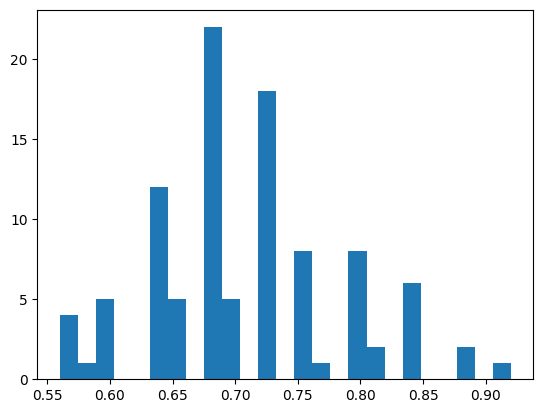

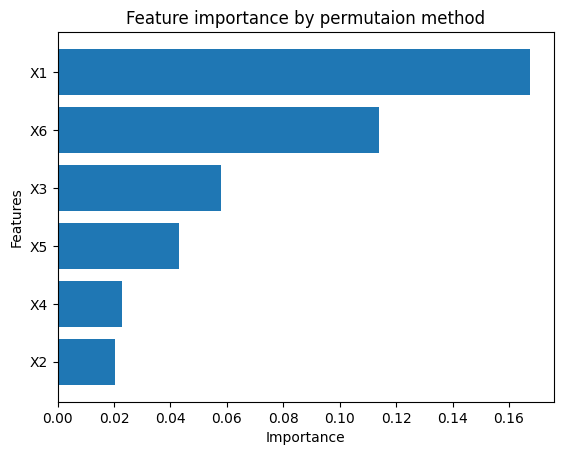

[[0.25041538 0.20189231]
 [0.09027692 0.45741538]]


In [18]:
n_split = 5 
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat, y=tar))
pipe = Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector(force=["X1","X6","mean"])),
    ("Scaler", StandardScaler()),
    ("SVC", SVC(kernel="rbf",C=100.00))
    ])
training.show_result(splits=splits,pipe=pipe,feat=feat,tar=tar)

X2 gotta go. 

## With 5 raw features (removing X2) 

In [5]:
df=pd.read_csv("../data/raw.csv")
features=[feature for feature in list(df.columns)[1:] if feature not in ["X2"]]
target=["Y"]
feat5=df[features]
tar=df[target]
# x_t, x_v, y_t, y_v= train_test_split(feat,tar, test_size=0.2, random_state=0, stratify=tar["Y"])
n_splits=5

eva_pipe=Pipeline([("DataCreater", training.data_creator()),("DataSelector",training.data_selector())])
tar_arr=np.ravel(tar.values)
eva_pipe.fit(X=feat5,y=tar)
eva_out=eva_pipe.transform(X=feat5)
eva_out.columns

Index(['X1', 'X3', 'X5', 'X6', 'mean', 'F_w_mean', 'above_4', 'above_5'], dtype='object')

In [6]:
eva_pipe["DataSelector"].sel_

,features,f score,p value,X1,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.283358,0.087541,0.432772,0.411873,0.646002,0.834661,0.333186,0.505629,0.617782,0.280160
1,X3,2.886959,0.091807,0.283358,1.000000,0.302618,0.358397,0.203750,0.676639,0.531664,0.517788,0.608386,0.486281,0.150838
3,X5,6.582716,0.011488,0.432772,0.358397,0.293115,1.000000,0.320195,0.768892,0.806886,0.611061,0.655418,0.599604,0.224522
4,X6,3.586849,0.060568,0.411873,0.203750,0.215888,0.320195,1.000000,0.615980,0.575047,0.352878,0.508618,0.527544,0.167669
5,mean,9.594031,0.002415,0.646002,0.676639,0.571577,0.768892,0.615980,1.000000,0.926757,0.689402,0.860335,0.797316,0.267983
6,F_w_mean,12.636760,0.000536,0.834661,0.531664,0.298208,0.806886,0.575047,0.926757,1.000000,0.615215,0.771013,0.780871,0.304112
8,above_4,9.617076,0.002387,0.505629,0.608386,0.534571,0.655418,0.508618,0.860335,0.771013,0.515033,1.000000,0.525982,0.268281
9,above_5,6.803083,0.010218,0.617782,0.486281,0.408057,0.599604,0.527544,0.797316,0.780871,0.272744,0.525982,1.000000,0.228057


In [7]:
eva_pipe["DataSelector"].total_

,features,f score,p value,X1,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.283358,0.087541,0.432772,0.411873,0.646002,0.834661,0.333186,0.505629,0.617782,0.280160
1,X3,2.886959,0.091807,0.283358,1.000000,0.302618,0.358397,0.203750,0.676639,0.531664,0.517788,0.608386,0.486281,0.150838
2,X4,0.516657,0.473623,0.087541,0.302618,1.000000,0.293115,0.215888,0.571577,0.298208,0.396752,0.534571,0.408057,0.064415
3,X5,6.582716,0.011488,0.432772,0.358397,0.293115,1.000000,0.320195,0.768892,0.806886,0.611061,0.655418,0.599604,0.224522
4,X6,3.586849,0.060568,0.411873,0.203750,0.215888,0.320195,1.000000,0.615980,0.575047,0.352878,0.508618,0.527544,0.167669
5,mean,9.594031,0.002415,0.646002,0.676639,0.571577,0.768892,0.615980,1.000000,0.926757,0.689402,0.860335,0.797316,0.267983
6,F_w_mean,12.636760,0.000536,0.834661,0.531664,0.298208,0.806886,0.575047,0.926757,1.000000,0.615215,0.771013,0.780871,0.304112
7,above_3,2.702677,0.102713,0.333186,0.517788,0.396752,0.611061,0.352878,0.689402,0.615215,1.000000,0.515033,0.272744,0.146051
8,above_4,9.617076,0.002387,0.505629,0.608386,0.534571,0.655418,0.508618,0.860335,0.771013,0.515033,1.000000,0.525982,0.268281
9,above_5,6.803083,0.010218,0.617782,0.486281,0.408057,0.599604,0.527544,0.797316,0.780871,0.272744,0.525982,1.000000,0.228057


In [8]:
range_feat5_combin = training.all_combin(eva_out.columns)
kernel_choice = ["rbf"]
margin_choice = [100,10,1,0.1,0.01,0.001]

n_split = 5
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat5, y=tar))

pipe = Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector()),
    ("Scaler", StandardScaler()),
    ("SVC", SVC())
    ])

jobs5 = list(itertools.product(range_feat5_combin, kernel_choice, margin_choice))

In [9]:
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(training.evaluate_combo)(
        list_f_sel_tuple=feat_sel, 
        dict_param={"SVC__kernel": kernel, 
                    "SVC__C": margin}, 
        splits=splits, 
        pipe=pipe, 
        feat=feat5, 
        tar=tar
    )
    for feat_sel, kernel, margin in jobs5
)

list_feat      = [r["features"] for r in results]
list_margin    = [r["SVC__C"] for r in results]
list_kernel    = [r["SVC__kernel"] for r in results]
list_acc_mean  = [r["acc_mean"] for r in results]
list_acc_std   = [r["acc_std"] for r in results]
list_f1_mean   = [r["f1_mean"] for r in results]
list_f1_std    = [r["f1_std"] for r in results]
list_above_73  = [r["above_73"] for r in results]
list_norm_above_73 = [r["norm_above_73"] for r in results] 
list_acc_mean_above_73 = [r["acc_mean_above_73"] for r in results]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [10]:
df_results = pd.DataFrame({
    #Hyper-parameters
    "features": list_feat,
    "margin": list_margin, 
    "kernel": list_kernel, 
    #Performances
    "acc_mean": list_acc_mean,
    "acc_std": list_acc_std,
    "f1_mean": list_f1_mean,
    "f1_std": list_f1_std,
    "above_73": list_above_73,
    "norm_above_73": list_norm_above_73, 
    "acc_mean_above_73": list_acc_mean_above_73
})

In [11]:
df_results.to_csv("../data/SVC_results_exhaust_raw5X2.csv", index=False) 

In [12]:
df_results.sort_values(by=["acc_mean_above_73"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
282,"X1,X6,mean",100.00,rbf,0.722723,0.082767,0.766347,0.072241,0.50,0.464970,0.189645
595,"X1,X3,X6,above_4",10.00,rbf,0.704615,0.088546,0.743995,0.076672,0.35,0.387177,0.002073
702,"X1,X6,mean,F_w_mean",100.00,rbf,0.696862,0.091543,0.742316,0.082287,0.36,0.358676,0.000147
223,"X1,X3,X6",10.00,rbf,0.696800,0.080794,0.744039,0.071610,0.28,0.340565,0.000020
222,"X1,X3,X6",100.00,rbf,0.696785,0.079219,0.744806,0.069376,0.28,0.337504,0.000014
...,...,...,...,...,...,...,...,...,...,...
508,"X6,mean,above_5",0.01,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
507,"X6,mean,above_5",0.10,rbf,0.547692,0.016165,0.707289,0.013742,0.00,0.000000,0.000000
506,"X6,mean,above_5",1.00,rbf,0.576369,0.078108,0.673036,0.087504,0.01,0.024597,0.000000
505,"X6,mean,above_5",10.00,rbf,0.581708,0.093819,0.649473,0.098211,0.06,0.056983,0.000000


In [13]:
df_results.sort_values(by=["f1_mean"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
282,"X1,X6,mean",100.0,rbf,0.722723,0.082767,0.766347,0.072241,0.50,0.464970,0.189645
222,"X1,X3,X6",100.0,rbf,0.696785,0.079219,0.744806,0.069376,0.28,0.337504,0.000014
223,"X1,X3,X6",10.0,rbf,0.696800,0.080794,0.744039,0.071610,0.28,0.340565,0.000020
595,"X1,X3,X6,above_4",10.0,rbf,0.704615,0.088546,0.743995,0.076672,0.35,0.387177,0.002073
702,"X1,X6,mean,F_w_mean",100.0,rbf,0.696862,0.091543,0.742316,0.082287,0.36,0.358676,0.000147
...,...,...,...,...,...,...,...,...,...,...
366,"X3,X5,above_5",100.0,rbf,0.517015,0.082422,0.540995,0.096960,0.01,0.004882,0.000000
8,X3,1.0,rbf,0.515415,0.063823,0.539760,0.096387,0.00,0.000387,0.000000
6,X3,100.0,rbf,0.514200,0.065642,0.539002,0.095620,0.00,0.000505,0.000000
367,"X3,X5,above_5",10.0,rbf,0.512692,0.095010,0.538966,0.100927,0.00,0.011092,0.000000


282 is clearly the best. 

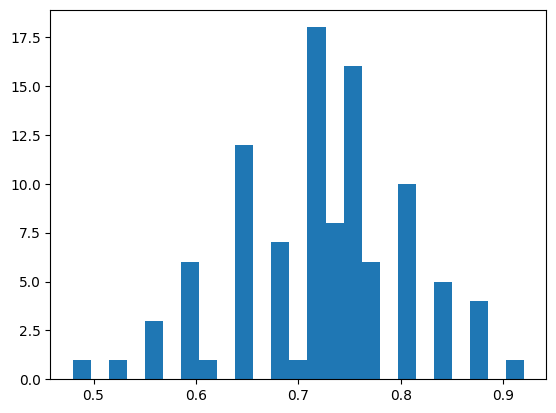

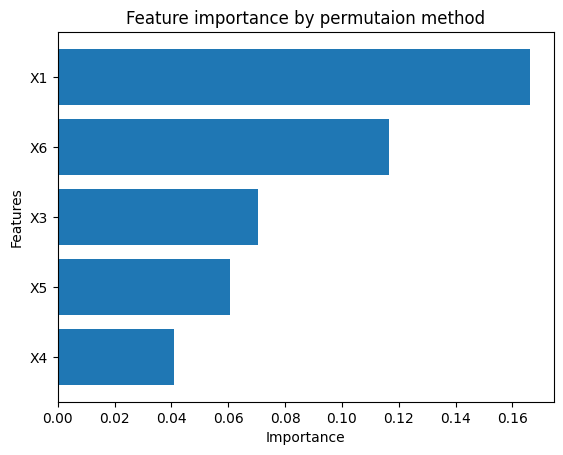

[[0.26453846 0.18776923]
 [0.08950769 0.45818462]]


In [14]:
#282 
n_split = 5 
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat5, y=tar))
pipe = Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector(force=["X1","X6","mean"])),
    ("Scaler", StandardScaler()),
    ("SVC", SVC(kernel="rbf",C=100.00))
    ])
training.show_result(splits=splits,pipe=pipe,feat=feat5,tar=tar)

## With 4 raw features (removing X2 X4) 

In [15]:
df=pd.read_csv("../data/raw.csv")
features=[feature for feature in list(df.columns)[1:] if feature not in ["X2", "X4"]]
target=["Y"]
feat4=df[features]
tar=df[target]
# x_t, x_v, y_t, y_v= train_test_split(feat,tar, test_size=0.2, random_state=0, stratify=tar["Y"])
n_splits=5

eva_pipe=Pipeline([("DataCreater", training.data_creator()),("DataSelector",training.data_selector())])
tar_arr=np.ravel(tar.values)
eva_pipe.fit(X=feat4,y=tar)
eva_out=eva_pipe.transform(X=feat4)
eva_out.columns

Index(['X1', 'X3', 'X5', 'X6', 'mean', 'F_w_mean', 'above_3', 'above_4',
       'above_5'],
      dtype='object')

In [16]:
eva_pipe["DataSelector"].sel_

,features,f score,p value,X1,X3,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.283358,0.432772,0.411873,0.714267,0.838825,0.367825,0.580152,0.683732,0.280160
1,X3,2.886959,0.091807,0.283358,1.000000,0.358397,0.203750,0.679422,0.527503,0.590444,0.632243,0.462141,0.150838
2,X5,6.582716,0.011488,0.432772,0.358397,1.000000,0.320195,0.788594,0.805157,0.651425,0.684307,0.617076,0.224522
3,X6,3.586849,0.060568,0.411873,0.203750,0.320195,1.000000,0.637932,0.573621,0.319799,0.546312,0.587815,0.167669
4,mean,11.142964,0.001114,0.714267,0.679422,0.788594,0.637932,1.000000,0.966938,0.708673,0.870014,0.819870,0.287147
5,F_w_mean,12.693583,0.000522,0.838825,0.527503,0.805157,0.573621,0.966938,1.000000,0.652805,0.825032,0.824128,0.304732
6,above_3,2.818124,0.095724,0.367825,0.590444,0.651425,0.319799,0.708673,0.652805,1.000000,0.553929,0.315653,0.149070
7,above_4,11.298950,0.001031,0.580152,0.632243,0.684307,0.546312,0.870014,0.825032,0.553929,1.000000,0.571427,0.288983
8,above_5,8.032573,0.005365,0.683732,0.462141,0.617076,0.587815,0.819870,0.824128,0.315653,0.571427,1.000000,0.246653


A key difference is that above_3 is in play now, but this might not be a good sign. 

In [17]:
eva_pipe["DataSelector"].total_

,features,f score,p value,X1,X3,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.283358,0.432772,0.411873,0.714267,0.838825,0.367825,0.580152,0.683732,0.280160
1,X3,2.886959,0.091807,0.283358,1.000000,0.358397,0.203750,0.679422,0.527503,0.590444,0.632243,0.462141,0.150838
2,X5,6.582716,0.011488,0.432772,0.358397,1.000000,0.320195,0.788594,0.805157,0.651425,0.684307,0.617076,0.224522
3,X6,3.586849,0.060568,0.411873,0.203750,0.320195,1.000000,0.637932,0.573621,0.319799,0.546312,0.587815,0.167669
4,mean,11.142964,0.001114,0.714267,0.679422,0.788594,0.637932,1.000000,0.966938,0.708673,0.870014,0.819870,0.287147
5,F_w_mean,12.693583,0.000522,0.838825,0.527503,0.805157,0.573621,0.966938,1.000000,0.652805,0.825032,0.824128,0.304732
6,above_3,2.818124,0.095724,0.367825,0.590444,0.651425,0.319799,0.708673,0.652805,1.000000,0.553929,0.315653,0.149070
7,above_4,11.298950,0.001031,0.580152,0.632243,0.684307,0.546312,0.870014,0.825032,0.553929,1.000000,0.571427,0.288983
8,above_5,8.032573,0.005365,0.683732,0.462141,0.617076,0.587815,0.819870,0.824128,0.315653,0.571427,1.000000,0.246653


In [18]:
range_feat4_combin = training.all_combin(eva_out.columns)
kernel_choice = ["rbf"]
margin_choice = [100,10,1,0.1,0.01,0.001]

n_split = 5
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat4, y=tar))

pipe = Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector()),
    ("Scaler", StandardScaler()),
    ("SVC", SVC())
    ])

jobs4 = list(itertools.product(range_feat4_combin, kernel_choice, margin_choice))

In [19]:
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(training.evaluate_combo)(
        list_f_sel_tuple=feat_sel, 
        dict_param={"SVC__kernel": kernel, 
                    "SVC__C": margin}, 
        splits=splits, 
        pipe=pipe, 
        feat=feat4, 
        tar=tar
    )
    for feat_sel, kernel, margin in jobs4
)

list_feat      = [r["features"] for r in results]
list_margin    = [r["SVC__C"] for r in results]
list_kernel    = [r["SVC__kernel"] for r in results]
list_acc_mean  = [r["acc_mean"] for r in results]
list_acc_std   = [r["acc_std"] for r in results]
list_f1_mean   = [r["f1_mean"] for r in results]
list_f1_std    = [r["f1_std"] for r in results]
list_above_73  = [r["above_73"] for r in results]
list_norm_above_73 = [r["norm_above_73"] for r in results] 
list_acc_mean_above_73 = [r["acc_mean_above_73"] for r in results]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [20]:
df_results = pd.DataFrame({
    #Hyper-parameters
    "features": list_feat,
    "margin": list_margin, 
    "kernel": list_kernel, 
    #Performances
    "acc_mean": list_acc_mean,
    "acc_std": list_acc_std,
    "f1_mean": list_f1_mean,
    "f1_std": list_f1_std,
    "above_73": list_above_73,
    "norm_above_73": list_norm_above_73, 
    "acc_mean_above_73": list_acc_mean_above_73
})

In [21]:
df_results.to_csv("../data/SVC_results_exhaust_raw4X24.csv", index=False) 

In [22]:
df_results.sort_values(by=["acc_mean_above_73"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
348,"X1,X6,mean",100.000,rbf,0.709615,0.091468,0.747281,0.079680,0.41,0.411822,0.012920
349,"X1,X6,mean",10.000,rbf,0.710092,0.084909,0.752843,0.073873,0.40,0.407314,0.009524
991,"X1,X6,mean,F_w_mean",10.000,rbf,0.702046,0.087683,0.742539,0.077388,0.36,0.374936,0.000716
1003,"X1,X6,mean,above_4",10.000,rbf,0.699738,0.088299,0.741547,0.079271,0.33,0.365906,0.000305
990,"X1,X6,mean,F_w_mean",100.000,rbf,0.697769,0.092665,0.739142,0.084155,0.38,0.363987,0.000252
...,...,...,...,...,...,...,...,...,...,...
1053,"X1,mean,F_w_mean,above_3",0.100,rbf,0.517462,0.049276,0.653678,0.080089,0.00,0.000008,0.000000
1054,"X1,mean,F_w_mean,above_3",0.010,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
1055,"X1,mean,F_w_mean,above_3",0.001,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
1056,"X1,mean,F_w_mean,above_4",100.000,rbf,0.615738,0.084187,0.668402,0.077928,0.09,0.087354,0.000000


In [23]:
df_results.sort_values(by=["f1_mean"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
349,"X1,X6,mean",10.0,rbf,0.710092,0.084909,0.752843,0.073873,0.40,0.407314,0.009524
348,"X1,X6,mean",100.0,rbf,0.709615,0.091468,0.747281,0.079680,0.41,0.411822,0.012920
276,"X1,X3,X6",100.0,rbf,0.696785,0.079219,0.744806,0.069376,0.28,0.337504,0.000014
277,"X1,X3,X6",10.0,rbf,0.696800,0.080794,0.744039,0.071610,0.28,0.340565,0.000020
991,"X1,X6,mean,F_w_mean",10.0,rbf,0.702046,0.087683,0.742539,0.077388,0.36,0.374936,0.000716
...,...,...,...,...,...,...,...,...,...,...
6,X3,100.0,rbf,0.514200,0.065642,0.539002,0.095620,0.00,0.000505,0.000000
7,X3,10.0,rbf,0.515400,0.065371,0.537653,0.095545,0.00,0.000514,0.000000
24,mean,100.0,rbf,0.510169,0.083357,0.537147,0.118291,0.00,0.004179,0.000000
126,"X3,above_3",100.0,rbf,0.467400,0.067514,0.535566,0.085075,0.00,0.000050,0.000000


Among 348 and 349, it is hard to say which one is better. The performance reduced quite a bit. 

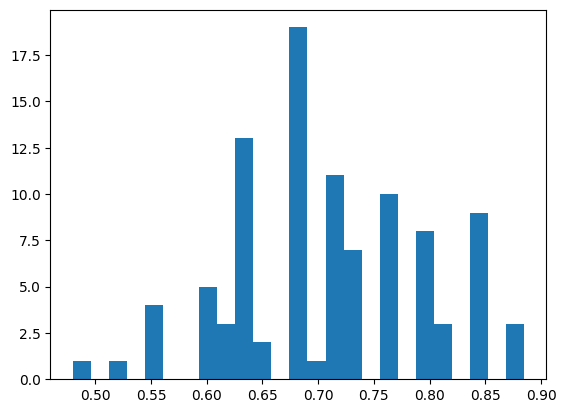

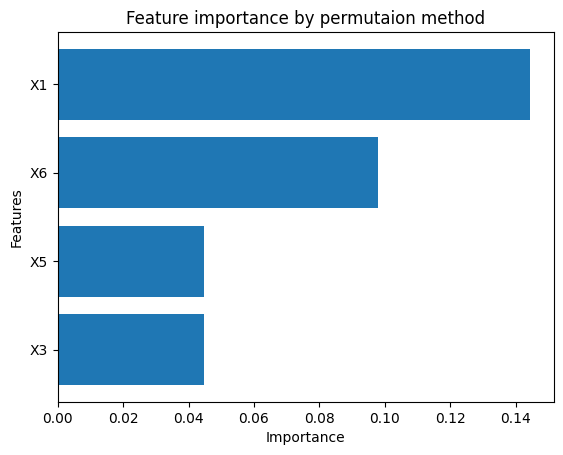

[[0.26618462 0.18612308]
 [0.10378462 0.44390769]]


In [24]:
#349 
n_split = 5 
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat4, y=tar))
pipe = Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector(force=["X1","X6","mean"])),
    ("Scaler", StandardScaler()),
    ("SVC", SVC(kernel="rbf",C=10.00))
    ])
training.show_result(splits=splits,pipe=pipe,feat=feat4,tar=tar)

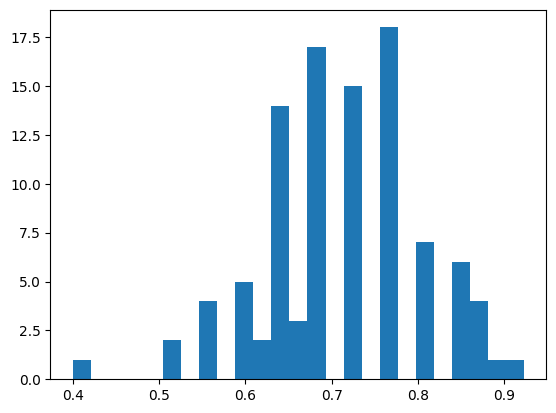

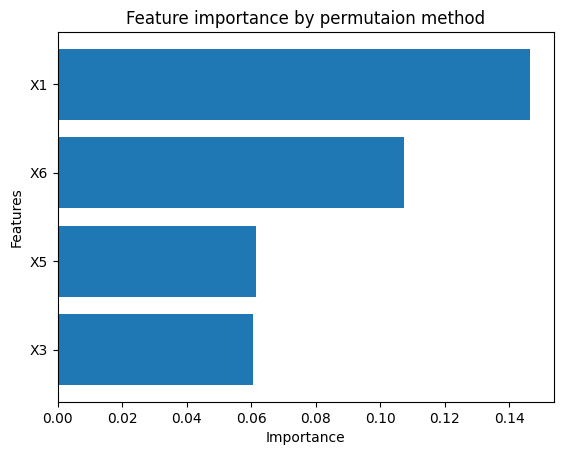

[[0.27795385 0.17435385]
 [0.11603077 0.43166154]]


In [25]:
#348 
n_split = 5 
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat4, y=tar))
pipe = Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector(force=["X1","X6","mean"])),
    ("Scaler", StandardScaler()),
    ("SVC", SVC(kernel="rbf",C=100.00))
    ])
training.show_result(splits=splits,pipe=pipe,feat=feat4,tar=tar)

Regardless, if we were to remove anything, it would be X3 or X5. 

## With 3 raw features (removing X2 X4 X3) 

In [26]:
df=pd.read_csv("../data/raw.csv")
features=[feature for feature in list(df.columns)[1:] if feature not in ["X2", "X4", "X3"]]
target=["Y"]
feat3=df[features]
tar=df[target]
# x_t, x_v, y_t, y_v= train_test_split(feat,tar, test_size=0.2, random_state=0, stratify=tar["Y"])
n_splits=5

eva_pipe=Pipeline([("DataCreater", training.data_creator()),("DataSelector",training.data_selector())])
tar_arr=np.ravel(tar.values)
eva_pipe.fit(X=feat3,y=tar)
eva_out=eva_pipe.transform(X=feat3)
eva_out.columns

Index(['X1', 'X5', 'X6', 'mean', 'F_w_mean', 'above_3', 'above_4', 'above_5'], dtype='object')

In [27]:
eva_pipe["DataSelector"].sel_

,features,f score,p value,X1,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.432772,0.411873,0.765431,0.858317,0.352904,0.645583,0.726571,0.280160
1,X5,6.582716,0.011488,0.432772,1.000000,0.320195,0.823188,0.806898,0.768167,0.714544,0.595599,0.224522
2,X6,3.586849,0.060568,0.411873,0.320195,1.000000,0.707332,0.584992,0.369696,0.603107,0.640635,0.167669
3,mean,11.383338,0.000989,0.765431,0.823188,0.707332,1.000000,0.979621,0.687057,0.856816,0.837401,0.289969
4,F_w_mean,12.481231,0.000578,0.858317,0.806898,0.584992,0.979621,1.000000,0.655195,0.837661,0.830659,0.302407
5,above_3,2.965672,0.087542,0.352904,0.768167,0.369696,0.687057,0.655195,1.000000,0.574723,0.312504,0.152833
6,above_4,9.744959,0.002238,0.645583,0.714544,0.603107,0.856816,0.837661,0.574723,1.000000,0.537836,0.269930
7,above_5,8.869829,0.003488,0.726571,0.595599,0.640635,0.837401,0.830659,0.312504,0.537836,1.000000,0.258371


In [28]:
eva_pipe["DataSelector"].total_

,features,f score,p value,X1,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.432772,0.411873,0.765431,0.858317,0.352904,0.645583,0.726571,0.280160
1,X5,6.582716,0.011488,0.432772,1.000000,0.320195,0.823188,0.806898,0.768167,0.714544,0.595599,0.224522
2,X6,3.586849,0.060568,0.411873,0.320195,1.000000,0.707332,0.584992,0.369696,0.603107,0.640635,0.167669
3,mean,11.383338,0.000989,0.765431,0.823188,0.707332,1.000000,0.979621,0.687057,0.856816,0.837401,0.289969
4,F_w_mean,12.481231,0.000578,0.858317,0.806898,0.584992,0.979621,1.000000,0.655195,0.837661,0.830659,0.302407
5,above_3,2.965672,0.087542,0.352904,0.768167,0.369696,0.687057,0.655195,1.000000,0.574723,0.312504,0.152833
6,above_4,9.744959,0.002238,0.645583,0.714544,0.603107,0.856816,0.837661,0.574723,1.000000,0.537836,0.269930
7,above_5,8.869829,0.003488,0.726571,0.595599,0.640635,0.837401,0.830659,0.312504,0.537836,1.000000,0.258371


In [29]:
range_feat3_combin = training.all_combin(eva_out.columns)
kernel_choice = ["rbf"]
margin_choice = [100,10,1,0.1,0.01,0.001]

n_split = 5
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat3, y=tar))

pipe = Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector()),
    ("Scaler", StandardScaler()),
    ("SVC", SVC())
    ])

jobs3 = list(itertools.product(range_feat3_combin, kernel_choice, margin_choice))

In [30]:
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(training.evaluate_combo)(
        list_f_sel_tuple=feat_sel, 
        dict_param={"SVC__kernel": kernel, 
                    "SVC__C": margin}, 
        splits=splits, 
        pipe=pipe, 
        feat=feat3, 
        tar=tar
    )
    for feat_sel, kernel, margin in jobs3 
)

list_feat      = [r["features"] for r in results]
list_margin    = [r["SVC__C"] for r in results]
list_kernel    = [r["SVC__kernel"] for r in results]
list_acc_mean  = [r["acc_mean"] for r in results]
list_acc_std   = [r["acc_std"] for r in results]
list_f1_mean   = [r["f1_mean"] for r in results]
list_f1_std    = [r["f1_std"] for r in results]
list_above_73  = [r["above_73"] for r in results]
list_norm_above_73 = [r["norm_above_73"] for r in results] 
list_acc_mean_above_73 = [r["acc_mean_above_73"] for r in results]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [31]:
df_results.to_csv("../data/SVC_results_exhaust_raw3X243.csv", index=False) 

In [32]:
df_results.sort_values(by=["acc_mean_above_73"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
348,"X1,X6,mean",100.000,rbf,0.709615,0.091468,0.747281,0.079680,0.41,0.411822,0.012920
349,"X1,X6,mean",10.000,rbf,0.710092,0.084909,0.752843,0.073873,0.40,0.407314,0.009524
991,"X1,X6,mean,F_w_mean",10.000,rbf,0.702046,0.087683,0.742539,0.077388,0.36,0.374936,0.000716
1003,"X1,X6,mean,above_4",10.000,rbf,0.699738,0.088299,0.741547,0.079271,0.33,0.365906,0.000305
990,"X1,X6,mean,F_w_mean",100.000,rbf,0.697769,0.092665,0.739142,0.084155,0.38,0.363987,0.000252
...,...,...,...,...,...,...,...,...,...,...
1053,"X1,mean,F_w_mean,above_3",0.100,rbf,0.517462,0.049276,0.653678,0.080089,0.00,0.000008,0.000000
1054,"X1,mean,F_w_mean,above_3",0.010,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
1055,"X1,mean,F_w_mean,above_3",0.001,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
1056,"X1,mean,F_w_mean,above_4",100.000,rbf,0.615738,0.084187,0.668402,0.077928,0.09,0.087354,0.000000


In [33]:
df_results.sort_values(by=["f1_mean"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
349,"X1,X6,mean",10.0,rbf,0.710092,0.084909,0.752843,0.073873,0.40,0.407314,0.009524
348,"X1,X6,mean",100.0,rbf,0.709615,0.091468,0.747281,0.079680,0.41,0.411822,0.012920
276,"X1,X3,X6",100.0,rbf,0.696785,0.079219,0.744806,0.069376,0.28,0.337504,0.000014
277,"X1,X3,X6",10.0,rbf,0.696800,0.080794,0.744039,0.071610,0.28,0.340565,0.000020
991,"X1,X6,mean,F_w_mean",10.0,rbf,0.702046,0.087683,0.742539,0.077388,0.36,0.374936,0.000716
...,...,...,...,...,...,...,...,...,...,...
6,X3,100.0,rbf,0.514200,0.065642,0.539002,0.095620,0.00,0.000505,0.000000
7,X3,10.0,rbf,0.515400,0.065371,0.537653,0.095545,0.00,0.000514,0.000000
24,mean,100.0,rbf,0.510169,0.083357,0.537147,0.118291,0.00,0.004179,0.000000
126,"X3,above_3",100.0,rbf,0.467400,0.067514,0.535566,0.085075,0.00,0.000050,0.000000


## With 3 raw features (removing X2 X4 X5) 

In [34]:
df=pd.read_csv("../data/raw.csv")
features=[feature for feature in list(df.columns)[1:] if feature not in ["X2", "X4", "X5"]]
target=["Y"]
feat3=df[features]
tar=df[target]
# x_t, x_v, y_t, y_v= train_test_split(feat,tar, test_size=0.2, random_state=0, stratify=tar["Y"])
n_splits=5

eva_pipe=Pipeline([("DataCreater", training.data_creator()),("DataSelector",training.data_selector())])
tar_arr=np.ravel(tar.values)
eva_pipe.fit(X=feat3,y=tar)
eva_out=eva_pipe.transform(X=feat3)
eva_out.columns

Index(['X1', 'X3', 'X6', 'mean', 'F_w_mean', 'above_4', 'above_5'], dtype='object')

In [35]:
eva_pipe["DataSelector"].sel_

,features,f score,p value,X1,X3,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.283358,0.411873,0.742239,0.932366,0.254083,0.572642,0.738850,0.280160
1,X3,2.886959,0.091807,0.283358,1.000000,0.203750,0.737905,0.528374,0.711903,0.627609,0.417503,0.150838
2,X6,3.586849,0.060568,0.411873,0.203750,1.000000,0.702607,0.621294,0.207669,0.596401,0.671972,0.167669
3,mean,9.606472,0.002400,0.742239,0.737905,0.702607,1.000000,0.933172,0.573588,0.825558,0.814657,0.268144
4,F_w_mean,11.687517,0.000852,0.932366,0.528374,0.621294,0.933172,1.000000,0.431670,0.749302,0.838511,0.293489
6,above_4,9.943270,0.002025,0.572642,0.627609,0.596401,0.825558,0.749302,0.340390,1.000000,0.516190,0.272461
7,above_5,7.296431,0.007876,0.738850,0.417503,0.671972,0.814657,0.838511,0.173275,0.516190,1.000000,0.235738


In [36]:
eva_pipe["DataSelector"].total_

,features,f score,p value,X1,X3,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.283358,0.411873,0.742239,0.932366,0.254083,0.572642,0.738850,0.280160
1,X3,2.886959,0.091807,0.283358,1.000000,0.203750,0.737905,0.528374,0.711903,0.627609,0.417503,0.150838
2,X6,3.586849,0.060568,0.411873,0.203750,1.000000,0.702607,0.621294,0.207669,0.596401,0.671972,0.167669
3,mean,9.606472,0.002400,0.742239,0.737905,0.702607,1.000000,0.933172,0.573588,0.825558,0.814657,0.268144
4,F_w_mean,11.687517,0.000852,0.932366,0.528374,0.621294,0.933172,1.000000,0.431670,0.749302,0.838511,0.293489
5,above_3,0.783510,0.377783,0.254083,0.711903,0.207669,0.573588,0.431670,1.000000,0.340390,0.173275,0.079240
6,above_4,9.943270,0.002025,0.572642,0.627609,0.596401,0.825558,0.749302,0.340390,1.000000,0.516190,0.272461
7,above_5,7.296431,0.007876,0.738850,0.417503,0.671972,0.814657,0.838511,0.173275,0.516190,1.000000,0.235738


In [37]:
range_feat3_combin = training.all_combin(eva_out.columns)
kernel_choice = ["rbf"]
margin_choice = [100,10,1,0.1,0.01,0.001]

n_split = 5
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat3, y=tar))

pipe = Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector()),
    ("Scaler", StandardScaler()),
    ("SVC", SVC())
    ])

jobs3 = list(itertools.product(range_feat3_combin, kernel_choice, margin_choice))

In [38]:
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(training.evaluate_combo)(
        list_f_sel_tuple=feat_sel, 
        dict_param={"SVC__kernel": kernel, 
                    "SVC__C": margin}, 
        splits=splits, 
        pipe=pipe, 
        feat=feat3, 
        tar=tar
    )
    for feat_sel, kernel, margin in jobs3 
)

list_feat      = [r["features"] for r in results]
list_margin    = [r["SVC__C"] for r in results]
list_kernel    = [r["SVC__kernel"] for r in results]
list_acc_mean  = [r["acc_mean"] for r in results]
list_acc_std   = [r["acc_std"] for r in results]
list_f1_mean   = [r["f1_mean"] for r in results]
list_f1_std    = [r["f1_std"] for r in results]
list_above_73  = [r["above_73"] for r in results]
list_norm_above_73 = [r["norm_above_73"] for r in results] 
list_acc_mean_above_73 = [r["acc_mean_above_73"] for r in results]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [39]:
df_results.to_csv("../data/SVC_results_exhaust_raw3X245.csv", index=False) 

In [40]:
df_results.sort_values(by=["acc_mean_above_73"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
348,"X1,X6,mean",100.000,rbf,0.709615,0.091468,0.747281,0.079680,0.41,0.411822,0.012920
349,"X1,X6,mean",10.000,rbf,0.710092,0.084909,0.752843,0.073873,0.40,0.407314,0.009524
991,"X1,X6,mean,F_w_mean",10.000,rbf,0.702046,0.087683,0.742539,0.077388,0.36,0.374936,0.000716
1003,"X1,X6,mean,above_4",10.000,rbf,0.699738,0.088299,0.741547,0.079271,0.33,0.365906,0.000305
990,"X1,X6,mean,F_w_mean",100.000,rbf,0.697769,0.092665,0.739142,0.084155,0.38,0.363987,0.000252
...,...,...,...,...,...,...,...,...,...,...
1053,"X1,mean,F_w_mean,above_3",0.100,rbf,0.517462,0.049276,0.653678,0.080089,0.00,0.000008,0.000000
1054,"X1,mean,F_w_mean,above_3",0.010,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
1055,"X1,mean,F_w_mean,above_3",0.001,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
1056,"X1,mean,F_w_mean,above_4",100.000,rbf,0.615738,0.084187,0.668402,0.077928,0.09,0.087354,0.000000


In [41]:
df_results.sort_values(by=["f1_mean"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
349,"X1,X6,mean",10.0,rbf,0.710092,0.084909,0.752843,0.073873,0.40,0.407314,0.009524
348,"X1,X6,mean",100.0,rbf,0.709615,0.091468,0.747281,0.079680,0.41,0.411822,0.012920
276,"X1,X3,X6",100.0,rbf,0.696785,0.079219,0.744806,0.069376,0.28,0.337504,0.000014
277,"X1,X3,X6",10.0,rbf,0.696800,0.080794,0.744039,0.071610,0.28,0.340565,0.000020
991,"X1,X6,mean,F_w_mean",10.0,rbf,0.702046,0.087683,0.742539,0.077388,0.36,0.374936,0.000716
...,...,...,...,...,...,...,...,...,...,...
6,X3,100.0,rbf,0.514200,0.065642,0.539002,0.095620,0.00,0.000505,0.000000
7,X3,10.0,rbf,0.515400,0.065371,0.537653,0.095545,0.00,0.000514,0.000000
24,mean,100.0,rbf,0.510169,0.083357,0.537147,0.118291,0.00,0.004179,0.000000
126,"X3,above_3",100.0,rbf,0.467400,0.067514,0.535566,0.085075,0.00,0.000050,0.000000


The result stopped improving, and my interest started reducing. 

## Result (Best for SVC): Using raw features X1 X3 X4 X5 X6, margin 100.0 and forced manufactured features X1,X6,mean. See detail at 282 in "With 5 raw features (removing X2)". 

In [42]:
df_best=pd.read_csv("../data/SVC_results_exhaust_raw5X2.csv")
df_best.sort_values(by=["acc_mean_above_73"], ascending=False) 

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
282,"X1,X6,mean",100.00,rbf,0.722723,0.082767,0.766347,0.072241,0.50,0.464970,0.189645
595,"X1,X3,X6,above_4",10.00,rbf,0.704615,0.088546,0.743995,0.076672,0.35,0.387177,0.002073
702,"X1,X6,mean,F_w_mean",100.00,rbf,0.696862,0.091543,0.742316,0.082287,0.36,0.358676,0.000147
223,"X1,X3,X6",10.00,rbf,0.696800,0.080794,0.744039,0.071610,0.28,0.340565,0.000020
222,"X1,X3,X6",100.00,rbf,0.696785,0.079219,0.744806,0.069376,0.28,0.337504,0.000014
...,...,...,...,...,...,...,...,...,...,...
508,"X6,mean,above_5",0.01,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
507,"X6,mean,above_5",0.10,rbf,0.547692,0.016165,0.707289,0.013742,0.00,0.000000,0.000000
506,"X6,mean,above_5",1.00,rbf,0.576369,0.078108,0.673036,0.087504,0.01,0.024597,0.000000
505,"X6,mean,above_5",10.00,rbf,0.581708,0.093819,0.649473,0.098211,0.06,0.056983,0.000000
